In [ ]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Clustering

In [ ]:
data = pd.read_csv('transactions_dataset.csv', sep = ";", decimal = ".")

In [ ]:
data['date_order'] = pd.to_datetime(data['date_order'])

#### Add Variables

In [ ]:
data['product_price'] = data['sales_net'] / data['quantity']

In [ ]:
data_sorted_encoded = pd.get_dummies(data, columns=['order_channel'], prefix='order_channel')

### New try with Reference Start and End dates

In [ ]:
# Sort the DataFrame by 'client_id' and 'date_order'
data_sorted_encoded = data_sorted_encoded.sort_values(by=['client_id', 'date_order'], ascending=[True, False])

# Calculate the time differences between consecutive unique order dates for each client
data_sorted_encoded['time_diff'] = data_sorted_encoded.groupby('client_id')['date_order'].diff()

# Convert the 'time_diff' column to timedelta type
data_sorted_encoded['time_diff'] = pd.to_timedelta(data_sorted_encoded['time_diff'])

# Create a new DataFrame excluding rows where time_diff is NaN (for the first order date of each client)
data_for_calculation = data_sorted_encoded.dropna(subset=['time_diff'])

# Exclude rows where time_diff is 0 from the mean calculation
data_for_calculation_nonzero = data_for_calculation[data_for_calculation['time_diff'].dt.days != 0]

# Calculate the mean purchase frequency for each client
mean_purchase_frequency = data_for_calculation_nonzero.groupby('client_id')['time_diff'].mean()

# Merge the mean purchase frequency back into the original DataFrame
data_sorted_encoded = pd.merge(data_sorted_encoded, mean_purchase_frequency.rename('mean_purchase_frequency'), left_on='client_id', right_index=True)

In [ ]:
data_sorted_encoded['mean_purchase_frequency_days'] = data_sorted_encoded['mean_purchase_frequency'].dt.days.abs()

In [ ]:
data_sorted_encoded['time_diff'] = data_sorted_encoded['time_diff'].dt.days.abs()

In [ ]:
data_sorted_encoded = data_sorted_encoded.drop(columns=['mean_purchase_frequency'])

In [ ]:
data_sorted_encoded.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,branch_id,product_price,order_channel_at the store,order_channel_by phone,order_channel_during the visit of a sales rep,order_channel_online,order_channel_other,time_diff,mean_purchase_frequency_days
59194999,2019-08-13,2019-08-13,1650826,6,60.858000,3,8470,20.286000,False,True,False,False,False,NaN,55
57977175,2019-07-31,2019-07-31,942611,6,41.538000,3,8470,13.846000,True,False,False,False,False,13.0,55
57982006,2019-07-31,2019-07-31,113967,6,63.673200,3,8470,21.224400,True,False,False,False,False,0.0,55
58337827,2019-07-31,2019-07-31,1522271,6,370.653924,401,8470,0.924324,True,False,False,False,False,0.0,55
57397993,2019-07-25,2019-07-25,1650826,6,60.858000,3,8470,20.286000,False,True,False,False,False,6.0,55


### Clustering Process

In [ ]:
cluster_columns = [
    'sales_net', 'quantity', 'product_price',
    'order_channel_at the store', 'order_channel_by phone',
    'order_channel_during the visit of a sales rep', 'order_channel_online',
    'order_channel_other', 'mean_purchase_frequency_days'
]

In [ ]:
# Assuming 'client_id' is the column representing unique clients in your original DataFrame
client_id_column = 'client_id'

# Drop rows with NaN values based on 'cluster_columns'
data_sorted_encoded = data_sorted_encoded.dropna(subset=cluster_columns)

# Extract relevant columns for clustering based on unique clients
X_unique_clients = data_sorted_encoded.groupby(client_id_column)[cluster_columns].mean()

# Standardize the features for unique clients
scaler = StandardScaler()
X_scaled_unique_clients = scaler.fit_transform(X_unique_clients)

In [ ]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)

# Fit and predict the cluster labels for unique clients
cluster_labels_unique_clients = kmeans.fit_predict(X_scaled_unique_clients)

# Create a DataFrame to store the cluster assignments for unique clients
cluster_results_unique_clients = pd.DataFrame({
    client_id_column: X_unique_clients.index,
    'cluster': cluster_labels_unique_clients
})

# Merge the cluster assignments back to the original DataFrame based on 'client_id'
data_sorted_encoded = pd.merge(data_sorted_encoded, cluster_results_unique_clients, on=client_id_column, how='left')

In [ ]:
data_sorted_encoded.describe()

,date_order,product_id,client_id,sales_net,quantity,branch_id,product_price,time_diff,mean_purchase_frequency_days,cluster
count,63230480,6.323048e+07,6.323048e+07,6.323048e+07,6.323048e+07,6.323048e+07,6.323048e+07,6.308097e+07,6.323048e+07,6.323048e+07
mean,2018-09-21 04:13:36.970039296,1.632308e+06,1.139833e+06,1.477583e+02,9.215392e+01,5.466660e+03,2.359679e+01,1.159873e+00,6.994897e+00,2.450696e+00
min,2017-09-22 00:00:00,1.500000e+01,6.000000e+00,-1.738817e+06,3.000000e+00,2.000000e+01,-5.743100e+04,0.000000e+00,1.000000e+00,0.000000e+00
25%,2018-03-19 00:00:00,8.517370e+05,5.658200e+05,1.415880e+01,3.000000e+00,2.907000e+03,7.126933e-01,0.000000e+00,2.000000e+00,2.000000e+00
50%,2018-09-21 00:00:00,1.621731e+06,1.152241e+06,4.424280e+01,5.000000e+00,5.226000e+03,4.259600e+00,0.000000e+00,3.000000e+00,3.000000e+00
75%,2019-03-21 00:00:00,2.434262e+06,1.706949e+06,1.314312e+02,2.100000e+01,8.361000e+03,1.629320e+01,0.000000e+00,6.000000e+00,3.000000e+00
max,2019-09-22 00:00:00,3.238833e+06,2.274517e+06,1.740456e+06,1.980010e+05,1.105700e+04,4.354381e+05,7.200000e+02,7.200000e+02,9.000000e+00
std,NaN,9.184552e+05,6.552470e+05,8.520293e+02,8.657866e+02,3.175132e+03,1.386423e+02,1.000273e+01,1.583015e+01,6.978004e-01


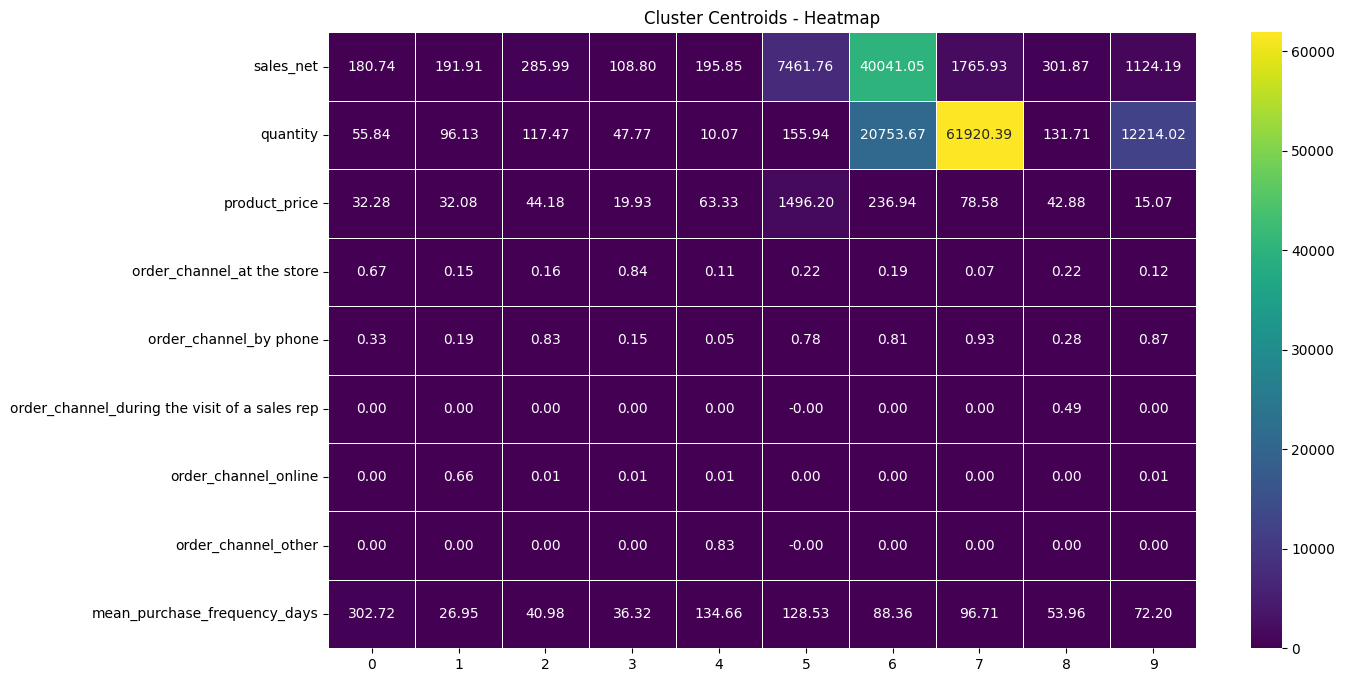

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cluster_columns)

# Create a heatmap to visualize cluster centroids
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_centroids.transpose(), annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Cluster Centroids - Heatmap')
plt.show()

In [ ]:
unique_clients_count_per_cluster = data_sorted_encoded.groupby('cluster')['client_id'].nunique()

# Display the resulting Series with the count of unique clients per cluster
print(unique_clients_count_per_cluster)

cluster
0     7072
1     6235
2    47873
3    87624
4      244
5      154
6       11
7       17
8      170
9      108
Name: client_id, dtype: int64


In [ ]:
b2c_cluster = data_sorted_encoded[data_sorted_encoded['cluster'] == 0] # enter b2c cluster number
b2c_cluster

,date_order,date_invoice,product_id,client_id,sales_net,quantity,branch_id,product_price,order_channel_at the store,order_channel_by phone,order_channel_during the visit of a sales rep,order_channel_online,order_channel_other,time_diff,mean_purchase_frequency_days,cluster
15898,2019-09-18,2019-09-30,1501829,165,219.70520,11,4072,19.97320,True,False,False,False,False,NaN,208,0
15899,2019-02-22,2019-02-22,582694,165,55.37664,11,4072,5.03424,True,False,False,False,False,208.0,208,0
15900,2019-02-22,2019-02-22,2203604,165,95.74900,5,4072,19.14980,True,False,False,False,False,0.0,208,0
21484,2019-06-11,2019-06-11,811155,453,88.92720,3,5240,29.64240,True,False,False,False,False,NaN,279,0
21485,2019-06-11,2019-06-11,575256,453,112.60800,5,5240,22.52160,True,False,False,False,False,0.0,279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63230393,2017-10-30,2017-10-31,334992,2274479,-76.89360,3,10742,-25.63120,True,False,False,False,False,0.0,485,0
63230394,2019-01-01,2019-01-01,1681540,2274504,24.77100,5,1292,4.95420,False,True,False,False,False,NaN,425,0
63230395,2017-11-02,2017-11-02,3235271,2274504,18.51960,3,1292,6.17320,True,False,False,False,False,425.0,425,0
63230396,2017-11-02,2017-11-02,2111702,2274504,16.06320,3,1292,5.35440,True,False,False,False,False,0.0,425,0


In [ ]:
b2c_cluster.describe()

,date_order,product_id,client_id,sales_net,quantity,branch_id,product_price,time_diff,mean_purchase_frequency_days,cluster
count,69587,6.958700e+04,6.958700e+04,69587.000000,69587.000000,69587.000000,69587.000000,62515.000000,69587.000000,69587.0
mean,2018-09-10 21:06:55.163751680,1.651715e+06,1.139085e+06,146.595533,58.185681,5552.855691,24.505344,50.076222,287.285571,0.0
min,2017-09-25 00:00:00,9.000000e+01,1.650000e+02,-112107.750000,3.000000,20.000000,-5990.938800,0.000000,154.000000,0.0
25%,2018-01-09 00:00:00,8.734330e+05,5.758830e+05,7.617600,3.000000,2744.000000,0.184000,0.000000,209.000000,0.0
50%,2018-08-27 00:00:00,1.647877e+06,1.129960e+06,42.310800,7.000000,5274.000000,3.494160,0.000000,258.000000,0.0
75%,2019-05-22 00:00:00,2.483953e+06,1.716567e+06,137.963507,25.000000,8807.000000,16.265600,0.000000,329.000000,0.0
max,2019-09-20 00:00:00,3.238164e+06,2.274504e+06,112107.750000,31601.000000,11057.000000,8687.928000,720.000000,720.000000,0.0
std,NaN,9.170043e+05,6.573755e+05,1253.363099,318.683404,3292.706288,117.681416,129.247718,107.945372,0.0


In [ ]:
# Cluster 0 describes the presumed household customers

### Extract Household costumers from dataframe to only use B2B costumers in the entire analysis

In [ ]:
data_b2b = data_sorted_encoded[data_sorted_encoded['client_id'].isin(data_sorted_encoded[data_sorted_encoded['cluster'] != 0]['client_id'])]

In [ ]:
data_b2b.describe()

,date_order,product_id,client_id,sales_net,quantity,branch_id,product_price,time_diff,mean_purchase_frequency_days,cluster
count,63160893,6.316089e+07,6.316089e+07,6.316089e+07,6.316089e+07,6.316089e+07,6.316089e+07,6.301846e+07,6.316089e+07,6.316089e+07
mean,2018-09-21 04:29:57.081600,1.632286e+06,1.139833e+06,1.477596e+02,9.219135e+01,5.466566e+03,2.359579e+01,1.111347e+00,6.686089e+00,2.453396e+00
min,2017-09-22 00:00:00,1.500000e+01,6.000000e+00,-1.738817e+06,3.000000e+00,2.000000e+01,-5.743100e+04,0.000000e+00,1.000000e+00,1.000000e+00
25%,2018-03-19 00:00:00,8.517370e+05,5.658130e+05,1.415880e+01,3.000000e+00,2.907000e+03,7.130000e-01,0.000000e+00,2.000000e+00,2.000000e+00
50%,2018-09-21 00:00:00,1.621731e+06,1.152256e+06,4.424280e+01,5.000000e+00,5.226000e+03,4.259600e+00,0.000000e+00,3.000000e+00,3.000000e+00
75%,2019-03-21 00:00:00,2.434262e+06,1.706895e+06,1.314220e+02,2.100000e+01,8.361000e+03,1.629320e+01,0.000000e+00,6.000000e+00,3.000000e+00
max,2019-09-22 00:00:00,3.238833e+06,2.274517e+06,1.740456e+06,1.980010e+05,1.105700e+04,4.354381e+05,6.910000e+02,6.690000e+02,9.000000e+00
std,NaN,9.184566e+05,6.552446e+05,8.514829e+02,8.661981e+02,3.174998e+03,1.386636e+02,9.011468e+00,1.230369e+01,6.934246e-01


In [ ]:
unique_client_ids = data_sorted_encoded['client_id'].nunique()

print(f"The number of unique client IDs is: {unique_client_ids}")

The number of unique client IDs is: 149508


### Download final dataset

In [ ]:
data_b2b.to_csv('final_dataset_b2b.csv', index=False)